# Crash Attribute Segmentation of New Jersey State Vehicle Accident Data
## 2. PCA & K-Means Clustering using SageMaker

This notebook outlines the process of performing Principle Component Analysis (PCA) on the normalized Accident table generated from the previous notebook and training a SageMaker K-Means algorithm to cluster municipalities with similar crash attributes. The goal of this process is to identify crash patterns across multiple municipalities within New Jersey.

### Accidents Data
The raw data used for this notebook was processed in the previous notebook which grouped individual crash cases by county-municipality and normalized all crash attribute columns.

### Machine Learning Workflow
The steps for PCA and K-Means training using SageMaker are as follows:
1. Dimensionality reduction with PCA
2. Feature engineering and data transformation
3. Clustering transformed data with k-means
4. Extracting trained model attributes and visualizing k clusters

### Analysis of Results
After training PCA and K-means models from both SageMaker and SciKit-Learn, an analysis of both methods will be documented in the Capstone report.

In [3]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

# sagemaker libraries
import boto3
import sagemaker

## Load Normalized Accidents Table
Load in CSV containing normalized Accident data.

In [4]:
crash_data_file = 'data/accidents_normalized_severity.csv'
# create a dataframe
crash_data_scaled = pd.read_csv(crash_data_file, header=0, delimiter=",") 
crash_data_scaled = crash_data_scaled.set_index('location')
print(crash_data_scaled.index)
print(crash_data_scaled.columns)
print(crash_data_scaled.shape)
crash_data_scaled.head()


Index(['ATLANTIC-ABSECON CITY', 'ATLANTIC-ATLANTIC CITY',
       'ATLANTIC-BUENA BORO', 'ATLANTIC-BUENA VISTA TWP',
       'ATLANTIC-EGG HARBOR CITY', 'ATLANTIC-EGG HARBOR TWP',
       'ATLANTIC-ESTELL MANOR CITY', 'ATLANTIC-FOLSOM BORO',
       'ATLANTIC-GALLOWAY TWP', 'ATLANTIC-HAMILTON TWP',
       ...
       'WARREN-KNOWLTON TWP', 'WARREN-LIBERTY TWP', 'WARREN-LOPATCONG TWP',
       'WARREN-MANSFIELD TWP', 'WARREN-OXFORD TWP', 'WARREN-PHILLIPSBURG TOWN',
       'WARREN-POHATCONG TWP', 'WARREN-WASHINGTON BORO',
       'WARREN-WASHINGTON TWP', 'WARREN-WHITE TWP'],
      dtype='object', name='location', length=511)
Index(['severity_rating5_4', 'severity_rating5_5', 'intersection_N',
       'intersection_Y', 'alcohol_involved_N', 'alcohol_involved_Y',
       'hazmat_involved_N', 'hazmat_involved_Y', 'hs_collision_type_1',
       'hs_collision_type_2',
       ...
       'first_harmful_event_57.0', 'first_harmful_event_58.0',
       'first_harmful_event_59.0', 'first_harmful_event_60.0',

,severity_rating5_4,severity_rating5_5,intersection_N,intersection_Y,alcohol_involved_N,alcohol_involved_Y,hazmat_involved_N,hazmat_involved_Y,hs_collision_type_1,hs_collision_type_2,...,first_harmful_event_57.0,first_harmful_event_58.0,first_harmful_event_59.0,first_harmful_event_60.0,first_harmful_event_61.0,first_harmful_event_62.0,first_harmful_event_69.0,first_harmful_event_99.0,flg_cell_in_use_N,flg_cell_in_use_Y
location,,,,,,,,,,,,,,,,,,,,,
ATLANTIC-ABSECON CITY,0.031250,0.066667,0.053571,0.026316,0.017647,0.227273,0.037433,0.0,0.045455,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.037838,0.000000
ATLANTIC-ATLANTIC CITY,0.250000,0.100000,0.223214,0.171053,0.164706,0.454545,0.197861,0.0,0.166667,0.206349,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.194595,0.333333
ATLANTIC-BUENA BORO,0.015625,0.016667,0.017857,0.013158,0.017647,0.000000,0.010695,0.0,0.000000,0.031746,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.010811,0.000000
ATLANTIC-BUENA VISTA TWP,0.070312,0.100000,0.107143,0.039474,0.076471,0.090909,0.074866,0.0,0.015152,0.047619,...,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.075676,0.000000
ATLANTIC-EGG HARBOR CITY,0.039062,0.066667,0.026786,0.078947,0.047059,0.045455,0.042781,0.0,0.030303,0.063492,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043243,0.000000


## 1. Dimensionality reduction with PCA

With 175 columns, it would be hard for a K-Means algorithm to cluster meaningful crash attributes. We only want attributes that hold meaningful weights and disregard those that are not importaint. To do this, the data will be dimensionally reduced using the built-in Sagemaker model for PCA.

### 1.1 Creating a Role and Bucket
To create a model, an IAM role needs to be specified and model attributes need to be stored in an S3 bucket.

In [5]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::489482010061:role/service-role/AmazonSageMaker-ExecutionRole-20200519T192540


In [6]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-2-489482010061



### 1.2 Defining a PCA Model

In [7]:
# define location to store model artifacts
prefix = 'counties'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))
# define a PCA model
from sagemaker import PCA

# N_COMPONENTS is current features - 1
# only a portion of these will be selected to use later
N_COMPONENTS = crash_data_scaled.columns.size - 1

print("N COMPONENTS: ", N_COMPONENTS)
pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

Training artifacts will be uploaded to: s3://sagemaker-us-east-2-489482010061/counties/
N COMPONENTS:  174


### 1.3 Convert Scaled Data to RecordSet Format
The RecordSet format is the required format for the training input data in all SageMaker built-in models. 

In [8]:
# convert df to np array
train_data_np = crash_data_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

### 1.4 Train the Model
Call the fit function on the PCA model, passing in our formatted, training data. This spins up a training instance to perform the training job.

In [9]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-05 15:59:33 Starting - Starting the training job...
2020-08-05 15:59:35 Starting - Launching requested ML instances.........
2020-08-05 16:01:07 Starting - Preparing the instances for training......
2020-08-05 16:02:33 Downloading - Downloading input data
2020-08-05 16:02:33 Training - Downloading the training image...Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/05/2020 16:02:49 INFO 140525513684800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[08/05/2020 16:02:49 INFO 140525513684800] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'175', u'mini_batch_size': u'500', u'num_compone


2020-08-05 16:03:24 Uploading - Uploading generated training model
2020-08-05 16:03:24 Completed - Training job completed
Training seconds: 73
Billable seconds: 73
CPU times: user 562 ms, sys: 40.5 ms, total: 603 ms
Wall time: 4min 12s


### 1.5 Accessing the PCA Model Attributes
After the model is trained, the underlying model parameters can be accessed by unzipping the TAR file and using the artifacts stored there to deploy a trained PCA model.

In [10]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-08-05-15-59-33-354'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/pca-2020-08-05-15-59-33-354/output/model.tar.gz


2304

### MXNet Array

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, the array can be loaded using MXNet.

In [11]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[          nan           nan           nan           nan           nan
           nan           nan           nan 1.7877087e-06 1.0247339e-03
 1.1104713e-03 1.8082830e-03 2.0420179e-03 2.3395282e-03 2.7943174e-03
 3.6086971e-03 3.8957719e-03 1.2204887e-01 1.5182629e-01 1.7552240e-01
 2.1342643e-01 2.6835349e-01 3.0108485e-01 3.2223874e-01 3.4016547e-01
 3.4654638e-01 3.7010103e-01 3.8426152e-01 4.0972129e-01 4.1332158e-01
 4.3975192e-01 4.4970000e-01 4.6285543e-01 4.8083946e-01 4.9149489e-01
 5.0492400e-01 5.2185410e-01 5.3381193e-01 5.4306364e-01 5.5131280e-01
 5.6777865e-01 5.8151573e-01 5.9305382e-01 6.0652268e-01 6.2050289e-01
 6.4338923e-01 6.6846496e-01 6.7223966e-01 6.8538439e-01 7.0091558e-01
 7.1893036e-01 7.2970694e-01 7.5954461e-01 7.7823859e-01 7.8761137e-01
 7.9229146e-01 8.0620337e-01 8.1216931e-01 8.4096950e-01 8.6461467e-01
 8.7232703e-01 8.8257480e-01 8.9238185e-01 9.1356951e-01 9.2106867e-01
 9.3156141e-01 9.5183140e-01 9.5554000e-01 9.7243738e-01 9.8151362e-01


## 2. Feature engineering and data transformation
Based on the chosen 'N_COMPONENTS' value chosen, the PCA model created 174 components. The goal of PCA is to reduce the number of components such that the top n chosen components make up 70% data varience. This section details this process.
### 2.1 PCA Model Attributes

Two types of model attributes are contained within the PCA model.

* **v**: The makeup of the principal components
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
'v' represents the combinations of features that make up each principle component.

's' represents an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

In [12]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

### 2.2 Data Variance
The top principal components, with the largest s values, are actually at the end of the 's' DataFrame. The following code prints out the 's' and 'v' values for the top n, principal components.

In [13]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components

# print a selection of s
print(s.iloc[start_idx:, :])
print(v.shape)
v.iloc[start_idx:, :]

             0
169   4.684526
170   4.979316
171   5.472179
172   6.842040
173  17.937126
(175, 174)


,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,173
169,0.003027,0.010546,-0.000974,0.001291,-0.002862,0.002557,-0.009896,0.018968,0.000165,0.000998,...,-0.012007,-0.006931,-0.021283,-0.016768,-0.024455,-0.027926,0.045104,-0.061444,-0.042443,0.024907
170,0.002014,0.007037,-0.000645,0.000864,-0.001906,0.001707,-0.006597,0.012648,0.000110,0.000666,...,0.036762,0.007412,0.015610,-0.007805,0.016071,-0.023491,-0.031485,-0.022915,0.024651,0.008650
171,0.004039,0.014056,-0.001299,0.001723,-0.003812,0.003406,-0.013194,0.025292,0.000220,0.001332,...,-0.020494,0.062419,0.003397,-0.006017,0.129579,-0.031012,-0.013394,-0.064345,0.056925,0.043555
172,0.001009,0.003516,-0.000322,0.000431,-0.000953,0.000853,-0.003299,0.006322,0.000055,0.000332,...,-0.400786,-0.289693,-0.077225,-0.162653,-0.311724,0.275457,-0.038472,0.095811,0.109093,0.061765
173,0.282060,-0.148717,0.212986,-0.236995,0.085115,0.319006,-0.107600,0.098400,0.000509,0.152498,...,0.005596,0.014991,0.004149,0.008211,0.002231,0.011842,0.002402,-0.030835,0.033649,0.124219
174,0.004574,-0.002411,0.003453,-0.003843,0.001381,0.005173,-0.001745,0.001595,0.000008,0.002472,...,0.009911,0.015170,-0.047549,0.005854,0.043615,0.037266,0.106690,0.015883,0.036388,0.070075


### 2.3 Calculating the explained variance
In this project, the top n principle components will be chosen that account for 70% data varience. To choose "n", the explained varience will be calculated using the following formula: 
\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

Using this formula, an "n" of 25 resulted in 71% data varience.

In [14]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## column length - 3, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

### 2.4 Determining the number of principle components

In [15]:
n_top_components = 25 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.7095656


In [16]:
# features
features_list = crash_data_scaled.columns.values
#print('Features: \n', features_list)
print('Features: \n', features_list.size)

Features: 
 175


### 2.5 Component Makeup
The following code examines the makeup of each PCA component based on the weightings of the original features that are included in the component. 
Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [21]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    ##print(v_1_row)
    v_1 = np.squeeze(v_1_row.values)
    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("SageMaker PCA Component Makeup, Component #" + str(component_num))
    plt.savefig("processed_data/Sagemaker/images/c_" + str(component_num) + ".png", bbox_inches='tight')
    plt.show()

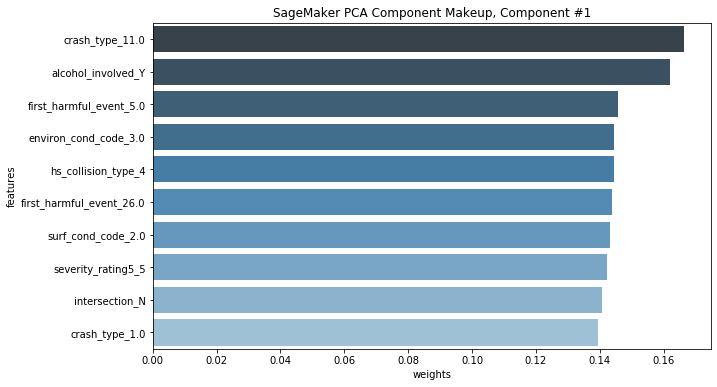

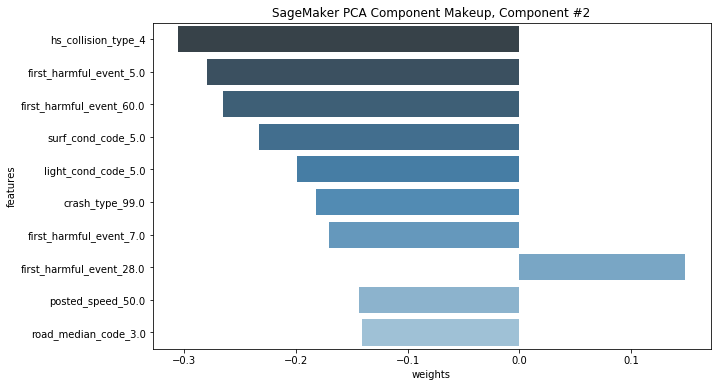

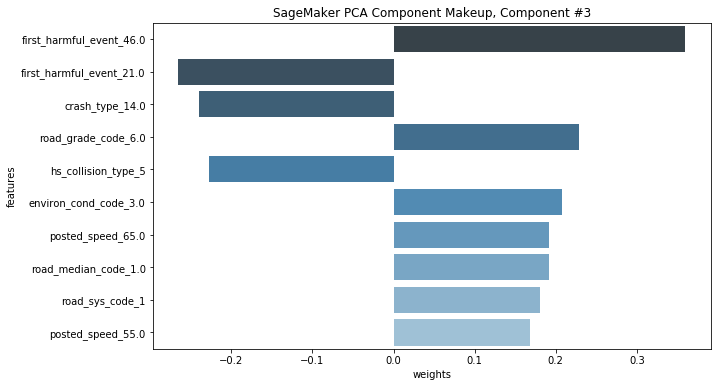

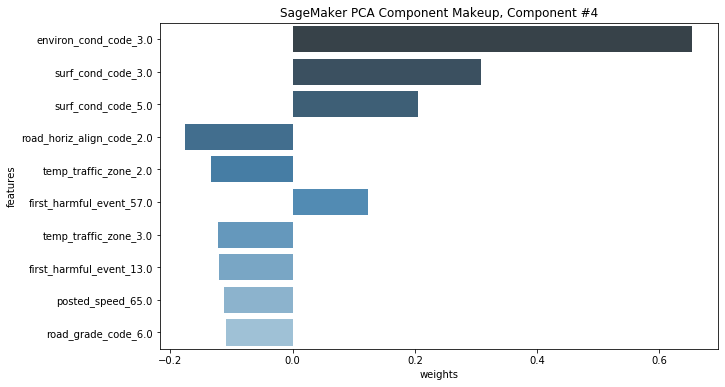

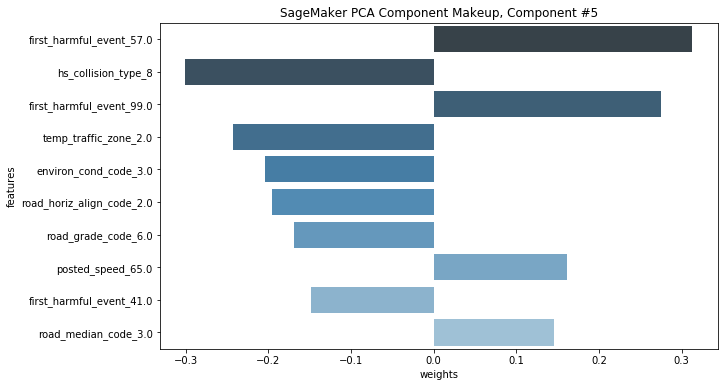

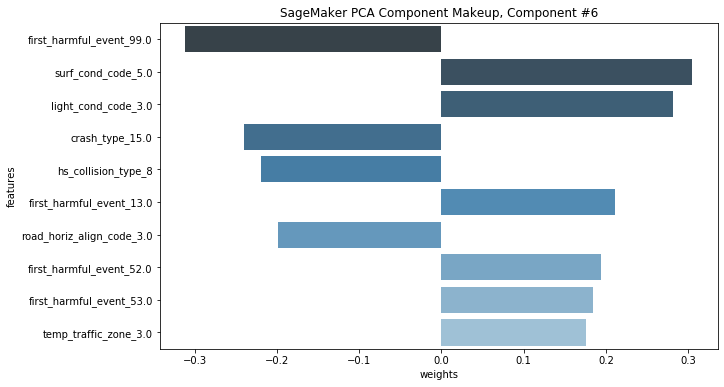

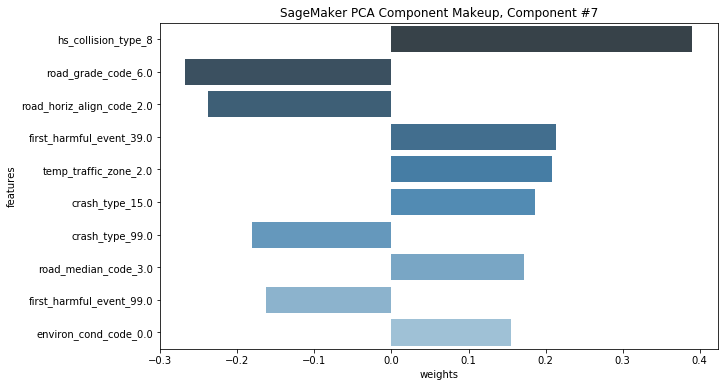

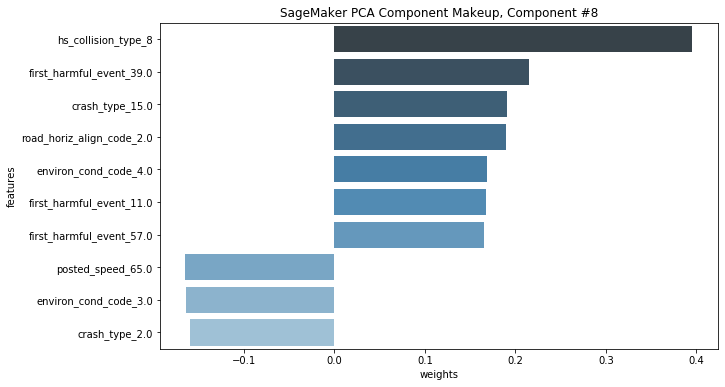

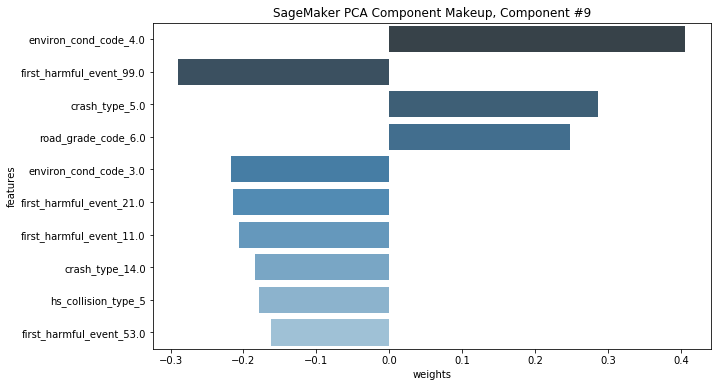

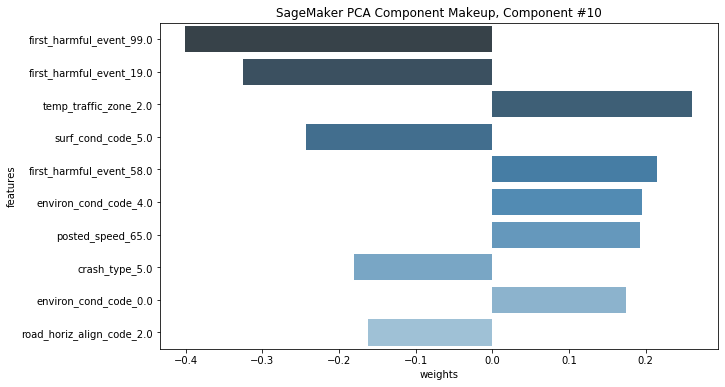

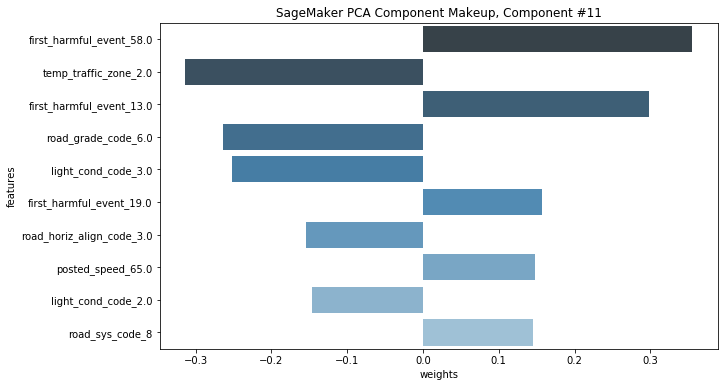

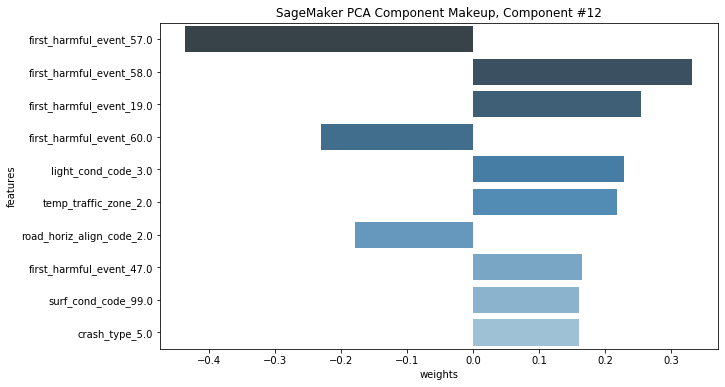

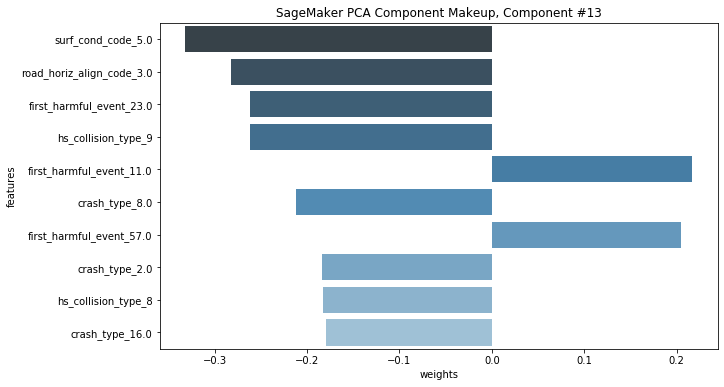

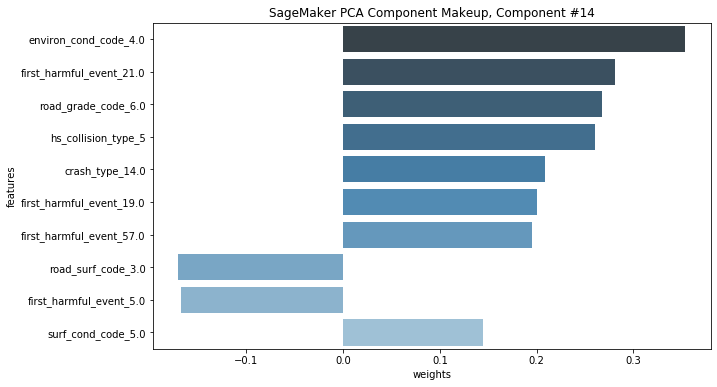

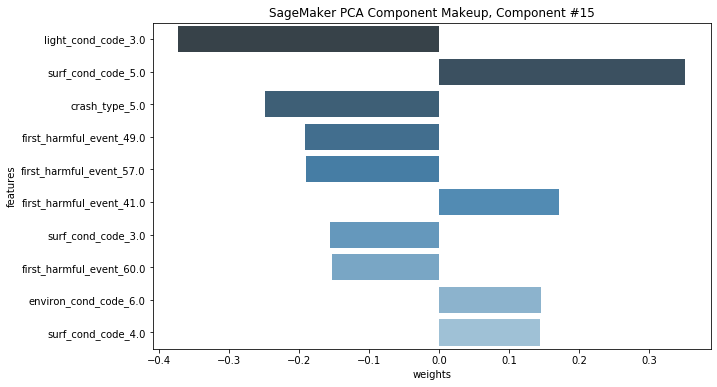

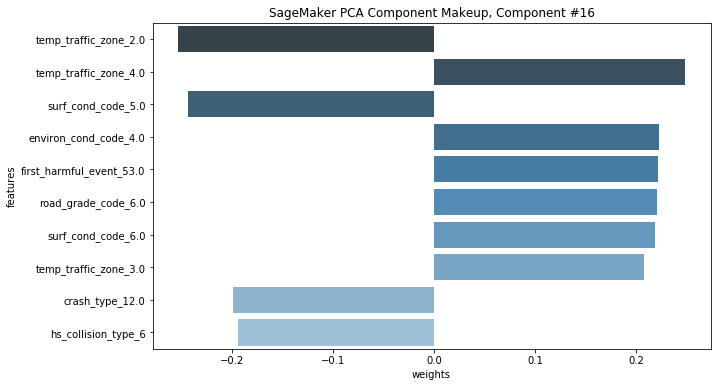

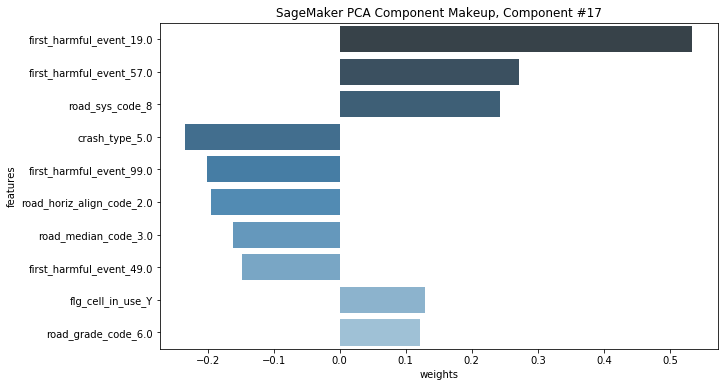

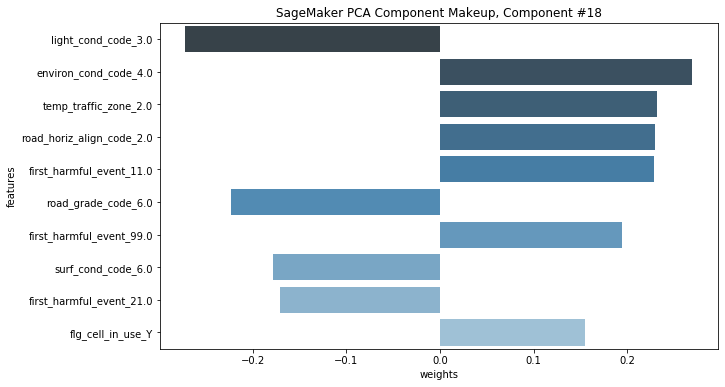

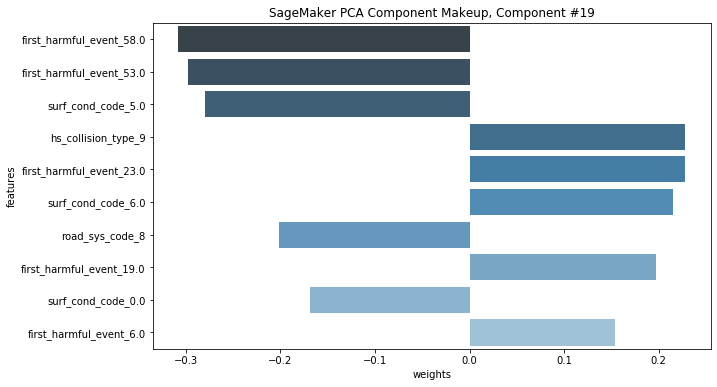

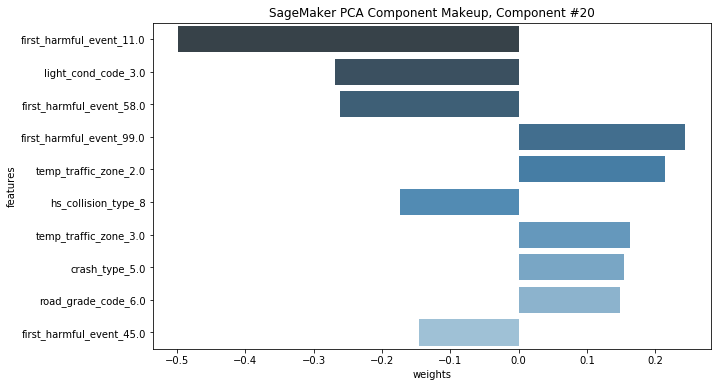

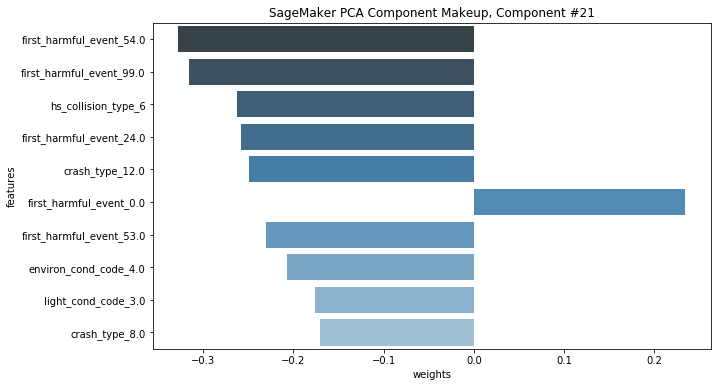

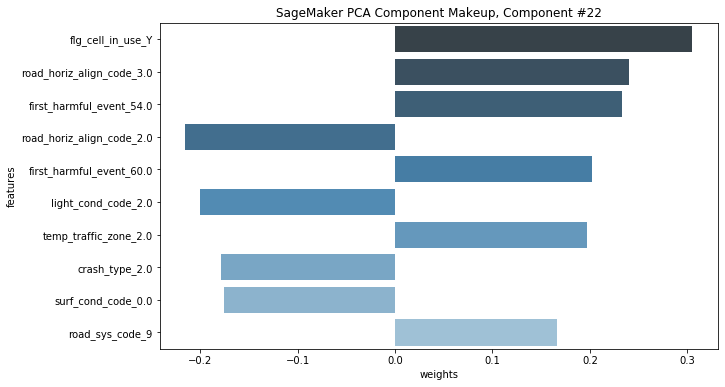

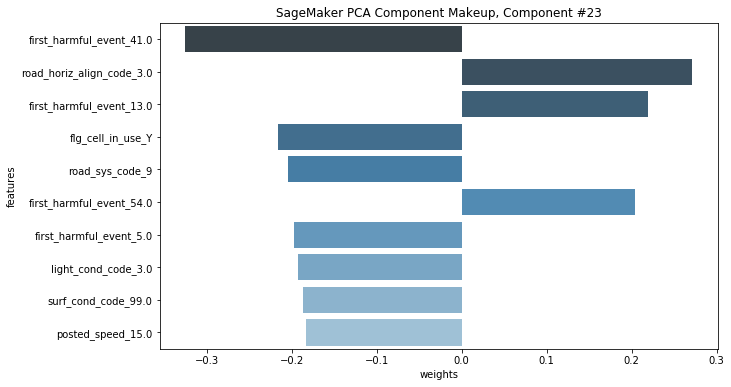

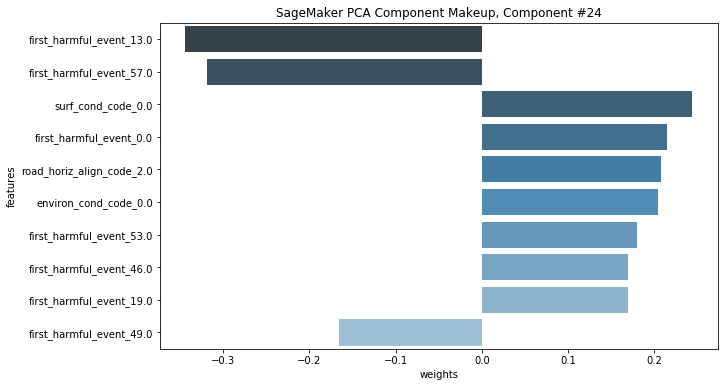

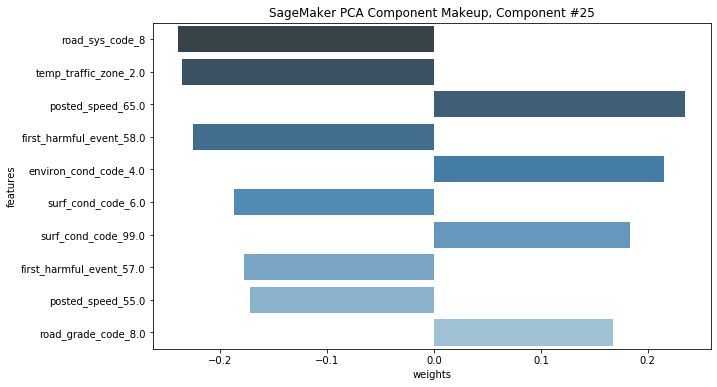

In [22]:
# display makeup of components
for num in range(1, 26):
    display_component(v, crash_data_scaled.columns.values, component_num=num, n_weights=10)

### 2.6 Deploying the PCA Model
The fitted PCA model will now be deployed to make "predictions". The original numpy dataset is passed into the model and transform the data using the model that is created. From this output, the largest n components are extracted to reduce the dimensionality of the PCA data.

In [17]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 292 ms, sys: 11.9 ms, total: 304 ms
Wall time: 7min 31s


In [18]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 1.3867393136024475e-06
      values: -3.177206963300705e-06
      values: -8.98377038538456e-07
      values: -1.5890691429376602e-06
      values: 6.842892616987228e-07
      values: -2.1958258002996445e-06
      values: -1.6113335732370615e-07
      values: -6.346672307699919e-07
      values: -1.6993908502627164e-09
      values: -1.6938429325819016e-08
      values: -1.4895922504365444e-06
      values: -8.690403774380684e-07
      values: 1.2682285159826279e-06
      values: 3.6894925870001316e-07
      values: -1.0139774531126022e-06
      values: -8.701390470378101e-07
      values: -9.100185707211494e-07
      values: 0.006418327335268259
      values: -0.0060010687448084354
      values: -0.0043632593005895615
      values: 0.008282315917313099
      values: 0.008303772658109665
      values: -0.004097726196050644
      values: 0.005059576127678156
      values: 0.009671020321547985
      values: 0.027047

In [19]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, crash_data_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param crash_data_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    counties_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        counties_transformed=counties_transformed.append([list(components)])

    # index by county, just like crash_data_scaled
    counties_transformed.index=crash_data_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    counties_transformed = counties_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return counties_transformed.iloc[:, ::-1]

A dataset is created where each county-municipality is described by the top n principle components that was analyzed earlier. Each of these components is a linear combination of the original feature space. Each of these components can be interpreted by analyzing the makeup of the component, shown previously.

In [20]:
# specify top n
top_n = n_top_components

# call your function and create a new dataframe
crash_data_transformed = create_transformed_df(train_pca, crash_data_scaled, n_top_components=top_n)
PCA_list = []
# add descriptive columns
for x in range(top_n):
    num = x + 1
    PCA_list.append("c_" + str(num))

print(PCA_list)
crash_data_transformed.columns=PCA_list 

# print result
print(crash_data_transformed.shape)
crash_data_transformed.head()

['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18', 'c_19', 'c_20', 'c_21', 'c_22', 'c_23', 'c_24', 'c_25']
(511, 25)


,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25
location,,,,,,,,,,,,,,,,,,,,,
ATLANTIC-ABSECON CITY,-0.258861,0.014501,-0.020325,-0.081433,0.048150,-0.057623,-0.057928,0.035114,-0.107243,-0.033827,...,0.074602,0.022651,0.086213,0.045274,-0.287012,0.103475,-0.028544,0.043530,0.032650,-0.009566
ATLANTIC-ATLANTIC CITY,0.771225,0.359157,-0.287680,-0.001793,0.044036,0.114233,-0.073310,-0.182439,0.130033,-0.105368,...,0.075960,-0.055333,-0.270728,-0.071234,-0.194767,0.173416,-0.023706,-0.045139,0.098290,-0.036079
ATLANTIC-BUENA BORO,-0.378835,-0.072236,0.075397,0.435153,-0.122853,0.010625,0.051015,-0.115615,-0.131223,-0.026250,...,0.042477,0.025887,0.051307,0.067645,0.058094,0.038722,-0.077201,0.022989,-0.012893,0.001263
ATLANTIC-BUENA VISTA TWP,0.112528,-0.313396,0.036641,0.397123,-0.139602,0.076991,-0.046225,-0.126018,-0.151449,-0.113909,...,0.014682,-0.014678,-0.011860,0.202232,-0.054808,-0.012896,-0.036583,-0.000539,0.001588,-0.014771
ATLANTIC-EGG HARBOR CITY,-0.311690,0.010645,-0.136297,0.008828,0.004250,-0.017810,0.018226,-0.038281,0.047999,-0.021742,...,0.009009,0.009084,-0.005980,-0.026823,0.008449,0.018210,-0.016987,-0.018936,-0.018670,-0.019170


In [21]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

## 3. Clustering transformed data with k-means
With the Accidents data dimensionally reduced to contain 25 PCA attributes, a K-means model will be trained to segment municipalities by similar attributes.
The following code defines a built-in K-means estimator in SageMaker. The "k" chosen is based on empirical data.

In [22]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 8

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

### 3.1 Create formatted, k-means training data

Convert the `crash_data_transformed` df into a numpy array and then into a RecordSet. This is the required format for passing training data into a `KMeans` model.

In [23]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = crash_data_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

### 3.2 Train the k-means model

Pass in the formatted training data and train the k-means model.

In [24]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-05 00:37:57 Starting - Starting the training job...
2020-08-05 00:37:58 Starting - Launching requested ML instances......
2020-08-05 00:39:00 Starting - Preparing the instances for training.........
2020-08-05 00:40:36 Downloading - Downloading input data...
2020-08-05 00:41:11 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/05/2020 00:41:28 INFO 140555811034944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u


2020-08-05 00:41:52 Uploading - Uploading generated training model
2020-08-05 00:42:24 Completed - Training job completed
Training seconds: 108
Billable seconds: 108
CPU times: user 612 ms, sys: 20.8 ms, total: 633 ms
Wall time: 4min 42s


In [25]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 310 ms, sys: 21 ms, total: 331 ms
Wall time: 8min 32s


### 3.3 Pass in the training data and assign predicted cluster labels

After deploying the model, pass in the k-means training data as a numpy array and get resultant predicted cluster labels for each data point.

In [26]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

## 4. Extracting trained model attributes and visualizing k clusters
### 4.1 Exploring resultant clusters
The following code shows how to extract cluster information for each county-municipality data point.

In [27]:
# print cluster info for first data point
data_idx = 0

print('County-Muni is: ', crash_data_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

County-Muni is:  ATLANTIC-ABSECON CITY

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 5.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.45556777715682983
    }
  }
}



### 4.2 Visualize the distribution of data over clusters

Get the cluster labels for each county-municipality data point and visualize the distribution of points over each cluster.

In [28]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

5.0    313
0.0    122
7.0     30
2.0     30
3.0      6
1.0      5
6.0      4
4.0      1
Name: 0, dtype: int64


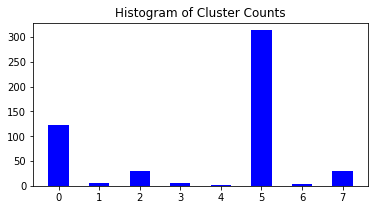

In [29]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

In [30]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

### 4.3 Access the k-means model attributes

In [31]:
# download and unzip the kmeans model file
kmeans_job_name = 'kmeans-2020-08-05-00-37-56-847'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')


2304

In [32]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[ 1.19091317e-01  1.83048211e-02  9.47807543e-03 -8.87682885e-02
   2.51938403e-02 -2.03959364e-02 -4.55957130e-02  3.49087548e-03
   1.83050558e-02 -3.74724530e-02 -1.35741532e-02 -9.73965600e-03
  -2.33696476e-02  1.58087369e-02 -4.28417102e-02  2.17308942e-02
   9.23568755e-03 -3.28841843e-02 -9.37592611e-03  3.19223106e-03
  -4.95733414e-03 -4.50522453e-03  9.81479138e-03 -3.71492538e-03
  -6.89371675e-03]
 [ 2.62230110e+00  2.27796674e-01  6.26872778e-01  3.26037258e-01
  -5.73118687e-01  3.68568510e-01 -6.94571584e-02 -1.46758974e-01
  -5.61504513e-02 -5.75972348e-03  3.69578421e-01 -4.93450701e-01
   8.66210759e-02  7.35103190e-02 -7.74343982e-02  2.57565916e-01
   4.51708212e-02  1.70956805e-01 -1.20503351e-01 -2.17148095e-01
  -8.93582404e-03  1.48268938e-01 -9.70697850e-02  5.79852536e-02
   2.75852621e-01]
 [ 1.23381877e+00 -2.45200574e-01  4.68873456e-02 -1.53562590e-01
   1.86787359e-03  2.91013792e-02  1.55928642e-01 -4.16598506e-02
  -2.46648453e-02  1.35670900e-01 -1

There is only 1 set of model parameters contained within the k-means model: the cluster centroid locations in PCA-transformed, component space.

* **centroids**: The location of the centers of each cluster in component space, identified by the k-means algorithm. 


In [33]:
# get all the centroids
cluster_centroids = pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns = crash_data_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25
0,0.119091,0.018305,0.009478,-0.088768,0.025194,-0.020396,-0.045596,0.003491,0.018305,-0.037472,...,0.021731,0.009236,-0.032884,-0.009376,0.003192,-0.004957,-0.004505,0.009815,-0.003715,-0.006894
1,2.622301,0.227797,0.626873,0.326037,-0.573119,0.368569,-0.069457,-0.146759,-0.056150,-0.005760,...,0.257566,0.045171,0.170957,-0.120503,-0.217148,-0.008936,0.148269,-0.097070,0.057985,0.275853
2,1.233819,-0.245201,0.046887,-0.153563,0.001868,0.029101,0.155929,-0.041660,-0.024665,0.135671,...,0.000811,-0.039300,-0.083739,0.073189,0.019465,0.025572,0.044834,0.012994,-0.083244,0.022621
3,2.681282,0.803756,0.085036,0.307496,0.288449,-0.201558,-0.067972,-0.199688,0.215495,-0.174466,...,0.022162,-0.009445,-0.016482,0.144260,0.021569,-0.189559,-0.203186,0.048482,0.020857,-0.060336
4,2.364399,-1.237779,-0.964054,-0.370334,-0.038567,0.645388,-0.086226,0.499484,0.358993,-1.042916,...,-0.514500,0.688050,0.026248,0.098510,0.350696,0.157904,-0.055549,1.005306,-0.069104,0.526249
5,-0.397592,0.043597,-0.011854,0.025848,0.002763,-0.002181,0.015104,0.004956,-0.010341,0.002156,...,-0.012703,-0.001265,0.012213,0.003525,0.002233,0.005255,-0.002539,0.000389,-0.000171,0.010943
6,3.292230,-0.529942,-1.045929,-0.120289,-0.213960,-0.261390,0.275581,-0.367663,-0.084617,-0.168487,...,0.196697,-0.254743,-0.054532,0.101002,-0.049815,-0.076410,-0.182429,0.068980,-0.006408,-0.114449
7,0.535310,-0.475916,0.148460,0.138019,-0.045922,0.020749,-0.139923,0.011972,-0.002194,0.066134,...,0.052456,0.036805,0.025922,-0.031234,-0.016941,0.014774,-0.020108,-0.006077,0.073568,-0.097390


### 4.4 Visualizing Centroids in Component Space
The following heatmap shows centroids of each cluster against their makeup of each PCA component. Based on this heatmap, clusters 1 and 4 have the highest values in component c_1. This means that county-municipalities within cluster 1 or 4 have similar crash attributes that are described in component c_1.

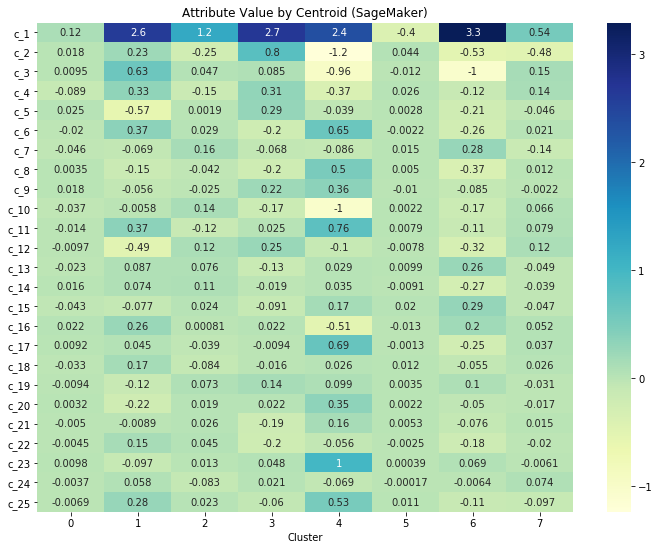

In [34]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu', annot=True)
ax.set_xlabel("Cluster")
ax.set_title("Attribute Value by Centroid (SageMaker)")
plt.show()

The previously defined `display_component` function is used to see the feature-level makeup.

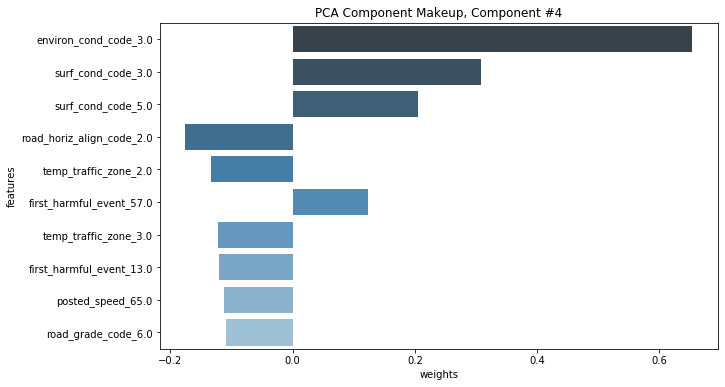

In [35]:
component_num=4
display_component(v, crash_data_scaled.columns.values, component_num=component_num)

### 4.5 Natural Groupings

The following code maps the cluster labels back to each individual county-municipality data point. This is helpful when examining which counties are naturally grouped together.

In [36]:
# add a 'labels' column to the dataframe
crash_data_transformed['labels'] = list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = crash_data_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_counties.head(10)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,labels
location,,,,,,,,,,,,,,,,,,,,,
HUNTERDON-RARITAN TWP,0.016111,-0.033755,-0.098887,-0.051318,-0.105048,0.031590,-0.124927,-0.036594,0.205477,-0.173349,...,-0.060670,-0.061957,0.001404,0.092892,-0.083047,-0.121955,-0.134924,-0.004842,-0.069760,0
GLOUCESTER-EAST GREENWICH TWP,-0.061431,-0.186566,0.162663,-0.171912,0.081362,-0.018725,0.086435,-0.108140,-0.049445,0.096734,...,-0.067547,0.024612,0.110990,0.019831,-0.004323,-0.104861,0.013203,-0.010567,0.089180,0
GLOUCESTER-ELK TWP,0.130273,-0.357060,0.182261,-0.085345,0.475083,0.052959,0.062038,0.289699,0.085547,0.037498,...,0.142275,0.062535,0.046554,-0.050700,-0.200195,-0.266382,-0.214431,-0.410255,-0.211610,0
GLOUCESTER-GLASSBORO BORO,0.188936,-0.187838,-0.122874,-0.007042,0.081978,0.003416,0.098406,-0.125952,0.372876,0.199389,...,-0.152174,0.189031,-0.221256,-0.244077,-0.097835,-0.004317,-0.007903,0.033840,-0.006971,0
GLOUCESTER-HARRISON TWP,0.117941,-0.109465,-0.269882,-0.040005,0.067692,0.079581,0.116446,-0.205421,0.139850,-0.122085,...,-0.063195,0.075245,-0.053791,-0.050286,0.065688,0.105984,-0.111668,-0.055219,0.019911,0
GLOUCESTER-LOGAN TWP,0.138660,-0.383128,0.146440,-0.181774,0.138625,0.007169,0.048250,-0.089997,-0.053226,0.071768,...,-0.086982,-0.020773,0.086052,-0.001066,0.104853,0.023102,0.032164,0.030010,0.090375,0
GLOUCESTER-WOOLWICH TWP,0.014777,-0.074887,-0.015060,-0.277972,-0.111024,0.244778,0.009228,-0.008734,-0.099778,0.017161,...,0.115816,0.039843,-0.173336,0.266483,-0.083872,-0.226012,0.110242,-0.152950,0.031238,0
HUDSON-BAYONNE CITY,0.677409,0.631641,-0.377059,-0.393283,-0.027941,0.348020,0.741489,0.409792,-0.822641,0.927069,...,0.525353,0.017264,-1.046194,0.625410,-0.247904,-0.513578,0.155614,0.641520,-0.320860,0
HUDSON-HOBOKEN CITY,-0.104845,0.303510,-0.340412,-0.015296,0.072151,-0.002420,-0.007489,0.034453,-0.164969,0.199161,...,0.218475,-0.155361,-0.180257,0.145269,0.224271,-0.064048,0.148989,0.071441,-0.237570,0


The above table can be queried by 'label' to display all county-municipalities that fall under a cluster.

In [37]:
# get all counties with label == 1
cluster = crash_data_transformed[crash_data_transformed['labels'] == 1]
cluster.head(100)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,labels
location,,,,,,,,,,,,,,,,,,,,,
CAMDEN-CAMDEN CITY,3.549162,0.988422,1.146778,-0.859984,-0.529852,2.236730,-0.387319,0.858537,-0.835433,-0.168932,...,0.236045,0.263902,-0.039504,0.075373,-0.189758,-0.035996,-0.175704,-0.443671,0.351846,1
CUMBERLAND-VINELAND CITY,2.512378,-0.285173,-0.584826,0.874458,0.277979,0.070579,0.043005,-0.139272,0.138038,-0.015205,...,0.290543,0.654780,-0.155577,-0.428394,-0.014118,0.392284,-0.204062,-0.085285,0.291657,1
MERCER-HAMILTON TWP,2.237823,0.112999,0.765560,0.510817,-0.522131,-0.256174,0.112182,-0.872701,0.012376,0.094584,...,0.096295,-0.005808,-0.320145,-0.236667,0.084004,0.000575,0.043026,0.134440,0.857279,1
MONMOUTH-MIDDLETOWN TWP,1.762463,-0.518987,0.341607,0.772389,-0.469787,0.136995,-0.533881,-0.353246,-0.253740,0.183191,...,-0.116688,0.180240,-0.054970,-0.559323,-0.321189,0.452617,0.052234,0.442676,-0.217103,1
PASSAIC-CLIFTON CITY,3.434157,0.956520,1.326559,0.147726,-1.672791,0.279455,0.237087,0.498829,0.589480,-0.222781,...,-0.331465,-0.061565,0.167321,0.082790,0.303441,0.079559,-0.340939,0.165313,-0.485842,1


In [38]:
folder = 'processed_data/'
cluster.to_csv(folder + 'cluster.csv')
crash_data_scaled.to_csv(folder + 'crash_data_scaled.csv')
cluster_centroids.to_csv(folder + 'cluster_centroids.csv')
cluster_df.to_csv(folder + 'cluster_df.csv')

In [39]:
print(cluster_info)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 5.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.45556777715682983
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.9849950671195984
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 5.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.5269841551780701
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.757214367389679
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 5.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
 

## Analysis of Results
The results from training the PCA and K-means models from this notebook will be discussed in the Capstone report.

In [40]:
for i in range(0,8):
    cluster_temp=crash_data_transformed[crash_data_transformed['labels']==i]
    print(i)
    print(cluster_temp.index.tolist())

0
['ATLANTIC-ATLANTIC CITY', 'ATLANTIC-BUENA VISTA TWP', 'ATLANTIC-HAMMONTON TOWN', 'ATLANTIC-PLEASANTVILLE CITY', 'BERGEN-CARLSTADT BORO', 'BERGEN-EAST RUTHERFORD BORO', 'BERGEN-ELMWOOD PARK BORO', 'BERGEN-ENGLEWOOD CITY', 'BERGEN-FAIR LAWN BORO', 'BERGEN-FORT LEE BORO', 'BERGEN-FRANKLIN LAKES BORO', 'BERGEN-HACKENSACK CITY', 'BERGEN-LODI BORO', 'BERGEN-MAHWAH TWP', 'BERGEN-MAYWOOD BORO', 'BERGEN-PARAMUS BORO', 'BERGEN-RAMSEY BORO', 'BERGEN-RIDGEFIELD PARK VILLAGE', 'BERGEN-RIDGEWOOD VILLAGE', 'BERGEN-RUTHERFORD BORO', 'BERGEN-SADDLE BROOK TWP', 'BERGEN-TEANECK TWP', 'BURLINGTON-BORDENTOWN TWP', 'BURLINGTON-BURLINGTON TWP', 'BURLINGTON-DELRAN TWP', 'BURLINGTON-EVESHAM TWP', 'BURLINGTON-FLORENCE TWP', 'BURLINGTON-LUMBERTON TWP', 'BURLINGTON-MAPLE SHADE TWP', 'BURLINGTON-MEDFORD TWP', 'BURLINGTON-MOORESTOWN TWP', 'BURLINGTON-SOUTHAMPTON TWP', 'BURLINGTON-TABERNACLE TWP', 'BURLINGTON-WOODLAND TWP', 'CAMDEN-GLOUCESTER CITY', 'CAMDEN-MAGNOLIA BORO', 'CAMDEN-VOORHEES TWP', 'CAPE MAY-LOWER T